# Generative Adversarial Networks #

First make sure we have a GPU available, or this will take a really long time to train. If you don't, refer to https://www.tensorflow.org/install/gpu

In [1]:
import tensorflow as tf


# maintain consistent performance
tf.random.set_seed(1)

# confirm GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


We'll load up the Fashion MNIST dataset, merge it all together since we're not doing train/test (our goal is image generation, not measuring accuracy at classification), and normalize the data to 0-1 floating point values.

In [2]:
from tensorflow.keras.datasets import fashion_mnist

# load the Fashion MNIST dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 1s 0us/step


In [3]:
import numpy as np

# merge the training and testing sets
dataset = np.concatenate([x_train, x_test], axis=0)
# normalize the images from [0,255] to [0,1]
dataset = np.expand_dims(dataset, -1).astype("float32") / 255

Now we will reshape the data to the dimensions needed by the CNN layers, shuffle, and batch it:

In [4]:
BATCH_SIZE = 64

# convolution layers work 3 channels
dataset = np.reshape(dataset, (-1, 28, 28, 1))
# create a tensorflow dataset object
dataset = tf.data.Dataset.from_tensor_slices(dataset)
# set the batch size otherwise it reads one image at a time
dataset = dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

2021-10-29 15:06:50.520019: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Now let's set up the model for our generator. Note the NOISE_DIM hyperparameter. From there we have three Conv2DTranspose layers to work our way to a final generated image.

In [5]:
from tensorflow import keras
from tensorflow.keras import layers

# the generator's input is a noise vector
# hyper-parameter that also requires fine-tuning
NOISE_DIM = 150

# design a generator model with upsampling layers
# in GANs practices, usually the generator has leaky relu activation while the discriminator has relu
generator = keras.models.Sequential([
  keras.layers.InputLayer(input_shape=(NOISE_DIM,)),
  layers.Dense(7*7*256),
  layers.Reshape(target_shape=(7, 7, 256)),
  layers.Conv2DTranspose(256, 3, activation="LeakyReLU", strides=2, padding="same"),
  layers.Conv2DTranspose(128, 3, activation="LeakyReLU", strides=2, padding="same"),
  layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")
])

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1894144   
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 256)       590080    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 128)       295040    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         1153      
Total params: 2,780,417
Trainable params: 2,780,417
Non-trainable params: 0
_________________________________________________________________


Next we'll make our discriminator model, using two Conv2D layers to downsample before going into a 64-neuron dense layer and a dropout to avoid overfitting. Its output is binary, as its job is to classify images as "real" or "fake"... until it can no longer tell the difference.

In [6]:
# design a discriminator with downsampling layers
discriminator = keras.models.Sequential([
  keras.layers.InputLayer(input_shape=(28, 28, 1)),
  layers.Conv2D(256, 3, activation="relu", strides=2, padding="same"),
  layers.Conv2D(128, 3, activation="relu", strides=2, padding="same"),
  layers.Flatten(),
  layers.Dense(64, activation="relu"),
  layers.Dropout(0.2),
  layers.Dense(1, activation="sigmoid")
])

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 256)       2560      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         295040    
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                401472    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 699,137
Trainable params: 699,137
Non-trainable params: 0
________________________________________________

Set up our optimizers, loss function, and accuracy metrics. Whee, more hyperparameters - getting the learning rates just right on both the generator and discriminator is the key. Otherwise it won't be stable.

In [7]:
# set different learning rates for the generator and the discriminator
# we want to maintain the game balance until we arrive at the nash-equilibria
# if the discriminator gets very strong or very weak the adversarial game fails
# higher learning rates impact the stability of the adversarial game severely
optimizerG = keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.5)
optimizerD = keras.optimizers.Adam(learning_rate=0.00003, beta_1=0.5)

# binary classifier (real or fake)
lossFn = keras.losses.BinaryCrossentropy(from_logits=True)

# accuracy metric
gAccMetric = tf.keras.metrics.BinaryAccuracy()
dAccMetric = tf.keras.metrics.BinaryAccuracy()

OK, let's tie them together. We initially feed our generator gaussian noise. Its "fake" outputs are concatenated to "real" data fed into the discriminator. The discriminator does its best to identify real vs. fake labels. Here we define the training function for the discriminator:

In [8]:
# observe the annotation allows for efficient native tensoflow compiling
@tf.function
def trainDStep(data):
  # the batch is (32,28,28,1), so extract 32 value
  batchSize = tf.shape(data)[0]
  # create a noise vector as generator input sampled from Gaussian Random Normal
  # As an exercise try sampling from a uniform distribution and observe the difference
  noise = tf.random.normal(shape=(batchSize, NOISE_DIM))

  # concatenate the real and fake labels
  y_true = tf.concat(
    [
      # the original data is real, labeled with 1
      tf.ones(batchSize, 1),
      # the forged data is fake, labeled with 0
      tf.zeros(batchSize, 1)
    ],
    axis=0
  )

  # record the calculated gradients
  with tf.GradientTape() as tape:
    # generate forged samples
    fake = generator(noise)
    # concatenate real data and forged data
    x = tf.concat([data, fake], axis=0)
    # see if the discriminator detects them
    y_pred = discriminator(x)
    # calculate the loss
    discriminatorLoss = lossFn(y_true, y_pred)

  # apply the backward path and update weights
  grads = tape.gradient(discriminatorLoss, discriminator.trainable_weights)
  optimizerD.apply_gradients(zip(grads, discriminator.trainable_weights))

  # report accuracy
  dAccMetric.update_state(y_true, y_pred)

  # return the loss for visualization
  return {
      "discriminator_loss": discriminatorLoss,
      "discriminator_accuracy": dAccMetric.result()
  }

And now, the training function for the generator. Remember the generator is trying not to get caught, and so it wants to be classified as real. Its loss function is based on how often the discriminator classifies its fake samples as real. This is in tension with the discriminator, which is trying to find fakes.

In [9]:
@tf.function
def trainGStep(data):
  batchSize = tf.shape(data)[0]
  noise = tf.random.normal(shape=(batchSize, NOISE_DIM))
  # when training the generator, we want it to maximize the probability that its
  # output is classified as real, remember the min-max game
  y_true = tf.ones(batchSize, 1)

  with tf.GradientTape() as tape:
    y_pred = discriminator(generator(noise))
    generatorLoss = lossFn(y_true, y_pred)

  grads = tape.gradient(generatorLoss, generator.trainable_weights)
  optimizerG.apply_gradients(zip(grads, generator.trainable_weights))

  gAccMetric.update_state(y_true, y_pred)

  return {
      "generator_loss": generatorLoss,
      "generator_accuracy": gAccMetric.result()
  }

Let's set up a handy function to visualize generated images as we train:

In [10]:
from matplotlib import pyplot as plt


def plotImages(model):
    images = model(np.random.normal(size=(81, NOISE_DIM)))

    plt.figure(figsize=(9, 9))

    for i, image in enumerate(images):
        plt.subplot(9,9,i+1)
        plt.imshow(np.squeeze(image, -1), cmap="Greys_r")
        plt.axis('off')

    plt.show();

Now it's showtime. Since the adversarial game is a delicate balance, we want to observe the results as training progresses. It may converge and then diverge again; it is very touchy stuff. Here we just go through each batch, train the discriminator, and train the generator each epoch. Every other epoch we'll peek at some generated images to see how they are looking, as the generator learns probability distributions to represent realistic images.

2021-10-29 15:07:41.400590: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


E:0, Loss G:0.6636, Loss D:0.5380, Acc G:%0.49, Acc D:%91.14


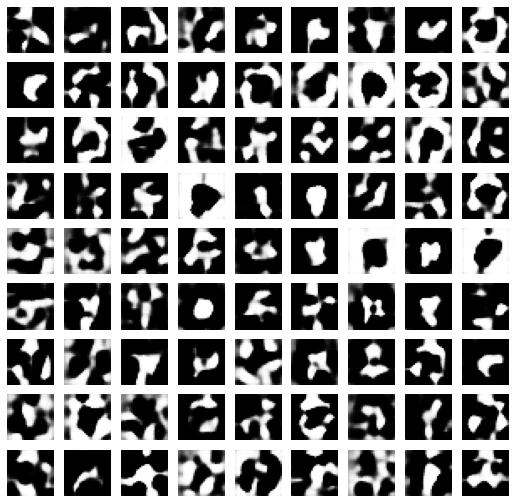

E:1, Loss G:0.6768, Loss D:0.5251, Acc G:%0.92, Acc D:%96.16


KeyboardInterrupt: 

In [11]:
# we don't use the model.fit method any more since the original GANs paper trained
# the discriminator for 5 steps and then the generator for 1 step
# the value 5 is subject to fine-tuning depending on the model design and the dataset
# in this example, training both for 1 step
# note: the adversarial game may diverge after it has converged
# that's why it is customary to visualize the generated images every few epochs
# some even put the images together into a video
for epoch in range(30):

  # accumulate the loss to calculate the average at the end of the epoch
  dLossSum = 0
  gLossSum = 0
  dAccSum = 0
  gAccSum = 0
  cnt = 0

  # loop the dataset one batch at a time
  for batch in dataset:

    # train the discriminator
    # remember you could repeat these 2 lines of code for K times
    dLoss = trainDStep(batch)
    dLossSum += dLoss['discriminator_loss']
    dAccSum += dLoss['discriminator_accuracy']

    # train the generator
    gLoss = trainGStep(batch)
    gLossSum += gLoss['generator_loss']
    gAccSum += gLoss['generator_accuracy']

    # increment the counter
    cnt += 1

  # log the performance
  print("E:{}, Loss G:{:0.4f}, Loss D:{:0.4f}, Acc G:%{:0.2f}, Acc D:%{:0.2f}".format(
      epoch,
      gLossSum/cnt,
      dLossSum/cnt,
      100 * gAccSum/cnt,
      100 * dAccSum/cnt
  ))
    
  if epoch % 2 == 0:
    plotImages(generator)

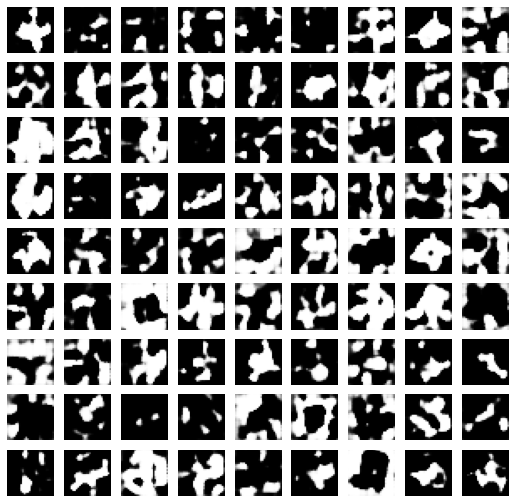

In [12]:
# generate some images with the trained model
# observe how fast it is compared to rendering an image with computer graphics algorithms
# that's why GANs can revolutize the video games industry by generating realistic scenes
# observe how the generated samples seem to belong to the same or similar class; this is the
# "mode collapse problem" of GAN's.
images = generator(np.random.normal(size=(81, NOISE_DIM)))

# plot the generated samples
from matplotlib import pyplot as plt

plt.figure(figsize=(9, 9))

for i, image in enumerate(images):
    plt.subplot(9,9,i+1)
    plt.imshow(np.squeeze(image, -1), cmap="Greys_r")
    plt.axis('off')

plt.show();